In [ ]:
# Final File to run 
# Dependencies File to Run:
#      1. Analysis.ipynb
#      2. Rho.ipynb
#      3. ML_Daily.ipynb
#      4. ML_Weekly.ipynb
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
import numpy as np
from scipy.optimize import minimize_scalar

# Load the daily merged data
data_folder = Path("data")
df_merge_daily = pd.read_csv(data_folder / 'df_merge_daily.csv', index_col=0, parse_dates=True)

# Display basic information
print("Data loaded successfully!")
print(f"Shape: {df_merge_daily.shape}")
print(f"\nFirst few rows:")
print(df_merge_daily.head())
print(f"\nData types:")
print(df_merge_daily.dtypes)
print(f"\nBasic statistics:")
print(df_merge_daily.describe())

Data loaded successfully!
Shape: (757, 46)

First few rows:
            sell_price_A  margin_A  sales_A  revenue_A  cost_A  \
date                                                             
2019-01-01         82.39     24.72     19.0    1565.41   57.67   
2019-01-02         82.39     24.72     41.0    3377.99   57.67   
2019-01-03         82.39     24.72     66.0    5437.74   57.67   
2019-01-04         82.39     24.72     77.0    6344.03   57.67   
2019-01-05         82.39     24.72     77.0    6344.03   57.67   

            log_sell_price_A  log_sales_A  log_revenue_A  sell_price_B  \
date                                                                     
2019-01-01          4.423528     2.995732       7.356542         36.19   
2019-01-02          4.423528     3.737670       8.125332         36.19   
2019-01-03          4.423528     4.204693       8.601303         36.19   
2019-01-04          4.423528     4.356709       8.755427         36.19   
2019-01-05          4.423528     

# OLS

In [6]:
def linear_regression_statsmodels(fdf, product ='A',other_products_flag = False  ,temporal_columns_flag=False):
    """
    Perform OLS regression using statsmodels to predict log_sales_{product} from df_model.
    """
    temporal_col_names = [ 'dayofmonth', 'month', 'year','is_weekend'] #'dayofweek',
    # 'dayofyear' and 'month' are correlated - exclude 'dayofyear'
    col_name_product = [f'log_sales_{product}']
    col_name_product_price = [f'log_sell_price_{product}']
    col_names_price = [ 'log_sell_price_A','log_sell_price_B','log_sell_price_C','log_sell_price_D','log_sell_price_E']
    if other_products_flag == False:
        col_names_price = col_name_product_price
    if temporal_columns_flag == False:
        temporal_col_names = []
    df_model = fdf[col_name_product+col_names_price+temporal_col_names].copy(deep=True)
    print(f"Running OLS regression for product: {product}")
    print("-"*70)
    print(df_model.columns.tolist())
    # Use df_model
    df_work = df_model.copy(deep=True)

    target = f'log_sales_{product}'
    if target not in df_work.columns:
        raise KeyError(f"{target} not found in df_model columns: {df_work.columns.tolist()}")

    # Select numeric features (exclude target)
    X = df_work.select_dtypes(include=["number"]).drop(columns=[target], errors='ignore')
    y = df_work[target]

    # Drop rows with NaNs
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask]
    y = y.loc[mask]

    # Remove constant columns
    X = X.loc[:, X.std() > 0]

    print(f"Target: {target}")
    print(f"Number of observations: {len(y)}")
    print(f"Features ({len(X.columns)}): {X.columns.tolist()}")

    # Fit OLS
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm)
    results = model.fit()
    beta0, beta1 = results.params[0], results.params[1]

    print("\n" + "="*70)
    print("STATSMODELS OLS REGRESSION SUMMARY")
    print("="*70)
    print(results.summary())

    # Store results
    _sm_ols_results = results
    
    return _sm_ols_results, beta0, beta1


In [7]:
lr_results = linear_regression_statsmodels(df_merge_daily, product ='A')


Running OLS regression for product: A
----------------------------------------------------------------------
['log_sales_A', 'log_sell_price_A']
Target: log_sales_A
Number of observations: 755
Features (1): ['log_sell_price_A']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_A   R-squared:                       0.609
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                     1173.
Date:                Wed, 17 Dec 2025   Prob (F-statistic):          1.07e-155
Time:                        13:01:49   Log-Likelihood:                -474.25
No. Observations:                 755   AIC:                             952.5
Df Residuals:                     753   BIC:                             961.8
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_12538/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


The equation that we get is:
$${logSales}_A = 19.05 - 3.3 \times {logPrice}_A$$
$$ PriceElasticity = \eta_A = -3.3$$

We have used **power-law demand function:**
$$ ln(q) = \beta_0 + \beta_1 ln(p) $$
$$ q(p) = e^{\beta_0} e^{\beta_1 ln(p)} = e^{\beta_0} e^{ln(p^{\beta_1})} = e^{\beta_0} p^{\beta1} $$
$$R(p) = p \times q(p) = e^{\beta_0} \times p^{\beta_1 + 1}$$
Using FOC (to maximize revenue):
$$\frac{dR}{dp} = 0 \implies \frac{e^{\beta_0} \times p^{\beta_1 + 1}}{dp} = 0$$
$$\implies \beta_1 = -1$$



In [8]:
data = df_merge_daily[['sell_price_A','sales_A','log_sales_A','log_sell_price_A']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_A':'price','sales_A':'sales',
        'log_sell_price_A':'ln_price','log_sales_A':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")


(757, 4)
(755, 4)
Regression coefficients:
β0 = 19.0534, β1 = -3.3033


In [9]:
# Demand function
def demand(p):
    return np.exp(beta0) * p**beta1

# Revenue function
def revenue(p):
    return p * demand(p)


In [12]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

Optimal price: 54.89
Max revenue: 18541.60
Sales: 337.80


# Product B

In [14]:
linear_regression_statsmodels(df_merge_daily, product ='B')

Running OLS regression for product: B
----------------------------------------------------------------------
['log_sales_B', 'log_sell_price_B']
Target: log_sales_B
Number of observations: 739
Features (1): ['log_sell_price_B']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_B   R-squared:                       0.561
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     942.0
Date:                Wed, 17 Dec 2025   Prob (F-statistic):          6.65e-134
Time:                        13:06:46   Log-Likelihood:                -655.43
No. Observations:                 739   AIC:                             1315.
Df Residuals:                     737   BIC:                             1324.
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_12538/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fec91c53dd0>,
 np.float64(21.47633681201881),
 np.float64(-4.86433295599159))

The equation that we get is:
$${logSales}_B = 21.48 - 4.86 \times {logPrice}_B$$
$$ PriceElasticity = \eta_D = -4.8$$

In [15]:
data = df_merge_daily[['sell_price_B','sales_B','log_sales_B','log_sell_price_B']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_B':'price','sales_B':'sales',
        'log_sell_price_B':'ln_price','log_sales_B':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")

(757, 4)
(739, 4)
Regression coefficients:
β0 = 21.4763, β1 = -4.8643


In [16]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

Optimal price: 24.09
Max revenue: 9709.05
Sales: 403.03


# Product C

In [28]:
linear_regression_statsmodels(df_merge_daily, product ='C')

Running OLS regression for product: C
----------------------------------------------------------------------
['log_sales_C', 'log_sell_price_C']
Target: log_sales_C
Number of observations: 737
Features (1): ['log_sell_price_C']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_C   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.445
Method:                 Least Squares   F-statistic:                     592.2
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           2.09e-96
Time:                        13:35:23   Log-Likelihood:                -838.89
No. Observations:                 737   AIC:                             1682.
Df Residuals:                     735   BIC:                             1691.
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_12538/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fec8c412d10>,
 np.float64(18.917927878168776),
 np.float64(-3.5988419054099965))

In [27]:
data = df_merge_daily[['sell_price_C','sales_C','log_sales_C','log_sell_price_C']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_C':'price','sales_C':'sales',
        'log_sell_price_C':'ln_price','log_sales_C':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")

(757, 4)
(737, 4)
Regression coefficients:
β0 = 18.9179, β1 = -3.5988


The equation that we get is:
$${logSales}_C =  (\beta_0 = 18.9) -  (\beta_1 =3.6)  \times {logPrice}_C$$
$$ PriceElasticity = \eta_C = -3.6$$

In [29]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

Optimal price: 29.59
Max revenue: 24698.94
Sales: 834.71


# Product D

In [20]:
linear_regression_statsmodels(df_merge_daily, product ='D')

Running OLS regression for product: D
----------------------------------------------------------------------
['log_sales_D', 'log_sell_price_D']
Target: log_sales_D
Number of observations: 677
Features (1): ['log_sell_price_D']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_D   R-squared:                       0.044
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     31.18
Date:                Wed, 17 Dec 2025   Prob (F-statistic):           3.41e-08
Time:                        13:23:37   Log-Likelihood:                -789.74
No. Observations:                 677   AIC:                             1583.
Df Residuals:                     675   BIC:                             1593.
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_12538/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fecaf2b5b50>,
 np.float64(14.310918719315545),
 np.float64(-3.1216692773064754))

In [23]:
data = df_merge_daily[['sell_price_D','sales_D','log_sales_D','log_sell_price_D']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_D':'price','sales_D':'sales',
        'log_sell_price_D':'ln_price','log_sales_D':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")

(757, 4)
(677, 4)
Regression coefficients:
β0 = 14.3109, β1 = -3.1217


The equation that we get is:
$$ {logSales}_D = (\beta_0=14.3) - (\beta_1 = 3.1) \times {logPrice}_D$$
$$ PriceElasticity = \eta_D = -3.1$$

In [24]:
# We maximize revenue numerically within a sensible range
res = minimize_scalar(lambda p: -revenue(p),
                      bounds=(min(data['price']), max(data['price'])*5),
                      method='bounded')

optimal_price = res.x
max_revenue = revenue(optimal_price)

print(f"Optimal price: {optimal_price:.2f}")
print(f"Max revenue: {max_revenue:.2f}")
print(f"Sales: {max_revenue/optimal_price:.2f}")

Optimal price: 36.19
Max revenue: 809.74
Sales: 22.37


(757, 4)
(677, 4)
Regression coefficients:
β0 = 14.3109, β1 = -3.1217


# Product E

In [18]:
linear_regression_statsmodels(df_merge_daily, product ='E')

Running OLS regression for product: E
----------------------------------------------------------------------
['log_sales_E', 'log_sell_price_E']
Target: log_sales_E
Number of observations: 645
Features (1): ['log_sell_price_E']

STATSMODELS OLS REGRESSION SUMMARY
                            OLS Regression Results                            
Dep. Variable:            log_sales_E   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.06426
Date:                Wed, 17 Dec 2025   Prob (F-statistic):              0.800
Time:                        13:18:09   Log-Likelihood:                -686.51
No. Observations:                 645   AIC:                             1377.
Df Residuals:                     643   BIC:                             1386.
Df Model:                           1                                         
Covariance Type:         

/tmp/ipykernel_12538/3216780893.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  beta0, beta1 = results.params[0], results.params[1]


(<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fecaec99150>,
 np.float64(4.123439944926384),
 np.float64(0.09675356213049444))

# p-value suggests that Sales E is not dependent on Price E

In [30]:
data = df_merge_daily[['sell_price_E','sales_E','log_sales_E','log_sell_price_E']].copy(deep=True)
data = data.rename(
    columns={
        'sell_price_E':'price','sales_E':'sales',
        'log_sell_price_E':'ln_price','log_sales_E':'ln_sales'
        }
    )
print(data.shape)
data = data.dropna()
print(data.shape)
# Fit log–log regression
X = sm.add_constant(data['ln_price'])
model = sm.OLS(data['ln_sales'], X).fit()
beta0, beta1 = model.params

print("Regression coefficients:")
print(f"β0 = {beta0:.4f}, β1 = {beta1:.4f}")

(757, 4)
(645, 4)
Regression coefficients:
β0 = 4.1234, β1 = 0.0968


In [31]:
df_merge_daily

,sell_price_A,margin_A,sales_A,revenue_A,cost_A,log_sell_price_A,log_sales_A,log_revenue_A,sell_price_B,margin_B,...,cost_E,log_sell_price_E,log_sales_E,log_revenue_E,dayofweek,is_weekend,dayofmonth,dayofyear,month,year
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01,82.39,24.72,19.0,1565.41,57.67,4.423528,2.995732,7.356542,36.19,10.86,...,NaN,NaN,NaN,NaN,1,0,1,1,1,2019
2019-01-02,82.39,24.72,41.0,3377.99,57.67,4.423528,3.737670,8.125332,36.19,10.86,...,NaN,NaN,NaN,NaN,2,0,2,2,1,2019
2019-01-03,82.39,24.72,66.0,5437.74,57.67,4.423528,4.204693,8.601303,36.19,10.86,...,NaN,NaN,NaN,NaN,3,0,3,3,1,2019
2019-01-04,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,NaN,NaN,NaN,NaN,4,0,4,4,1,2019
2019-01-05,82.39,24.72,77.0,6344.03,57.67,4.423528,4.356709,8.755427,36.19,10.86,...,NaN,NaN,NaN,NaN,5,1,5,5,1,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-23,98.89,29.67,32.0,3164.48,69.22,4.604070,3.496508,8.060060,38.39,11.52,...,153.92,5.397665,4.882802,10.268359,5,1,23,23,1,2021
2021-01-24,98.89,29.67,29.0,2867.81,69.22,4.604070,3.401197,7.961653,38.39,11.52,...,153.92,5.397665,5.236442,10.624260,6,1,24,24,1,2021
2021-01-25,98.89,29.67,53.0,5241.17,69.22,4.604070,3.988984,8.564491,38.39,11.52,...,153.92,5.397665,5.424950,10.813683,0,0,25,25,1,2021


The equation that we get is:
$${logSales}_C = \\beta_0 - \\beta_1 \\times {logPrice}_C$$

In [ ]:
linear_regression_statsmodels(df_merge_daily, product ='C')

# Price Optimization Visualizations

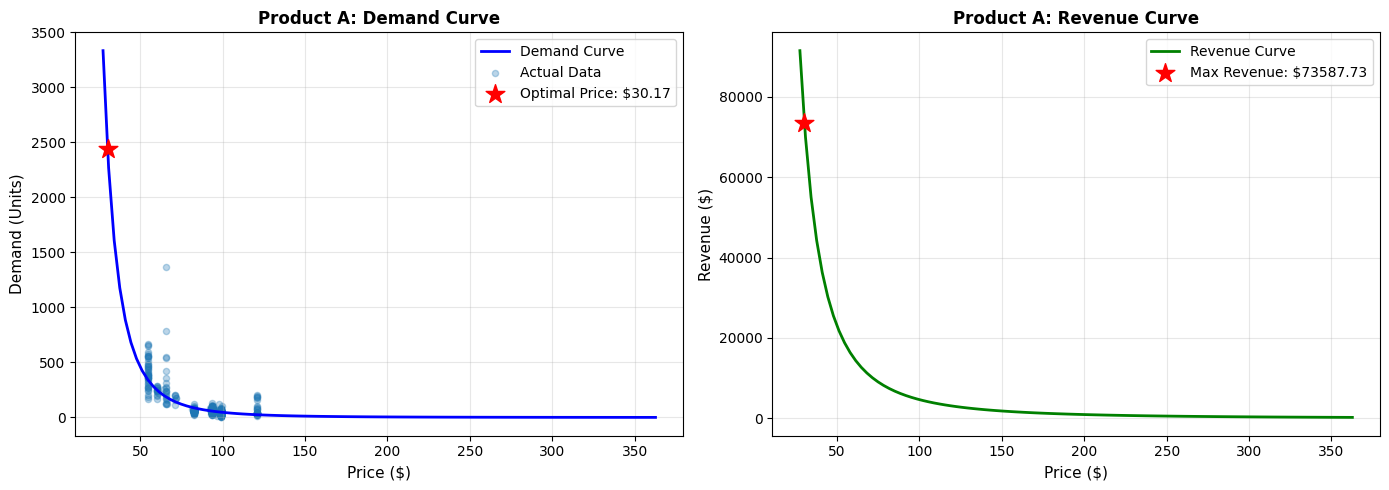


Product A:
  Optimal Price: $30.17
  Max Revenue: $73587.73
  Demand at Optimal Price: 2439.05 units


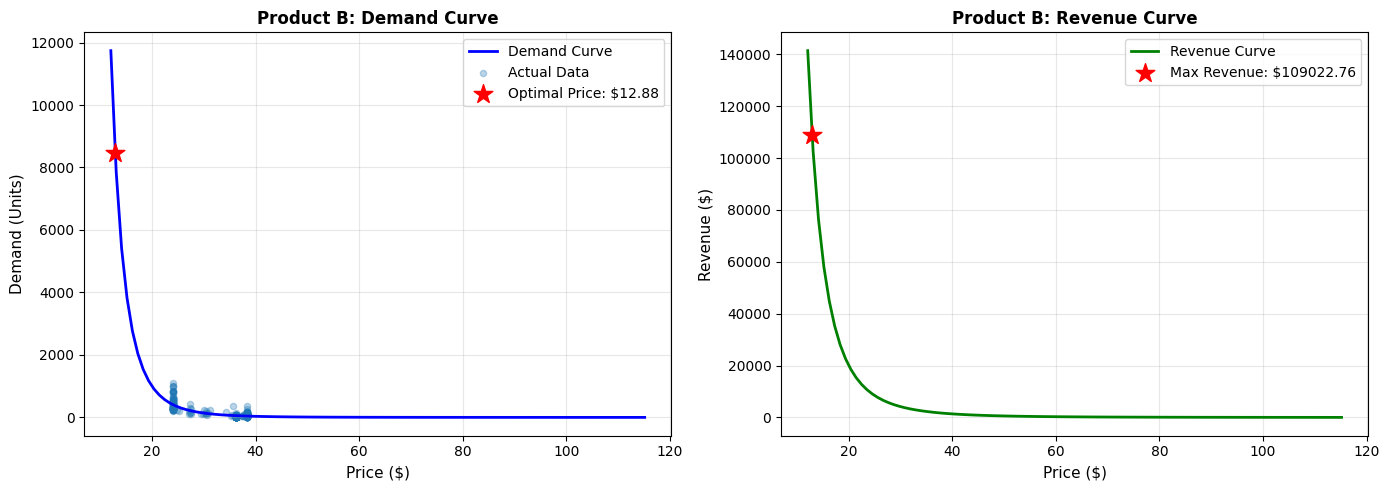


Product B:
  Optimal Price: $12.88
  Max Revenue: $109022.76
  Demand at Optimal Price: 8462.22 units


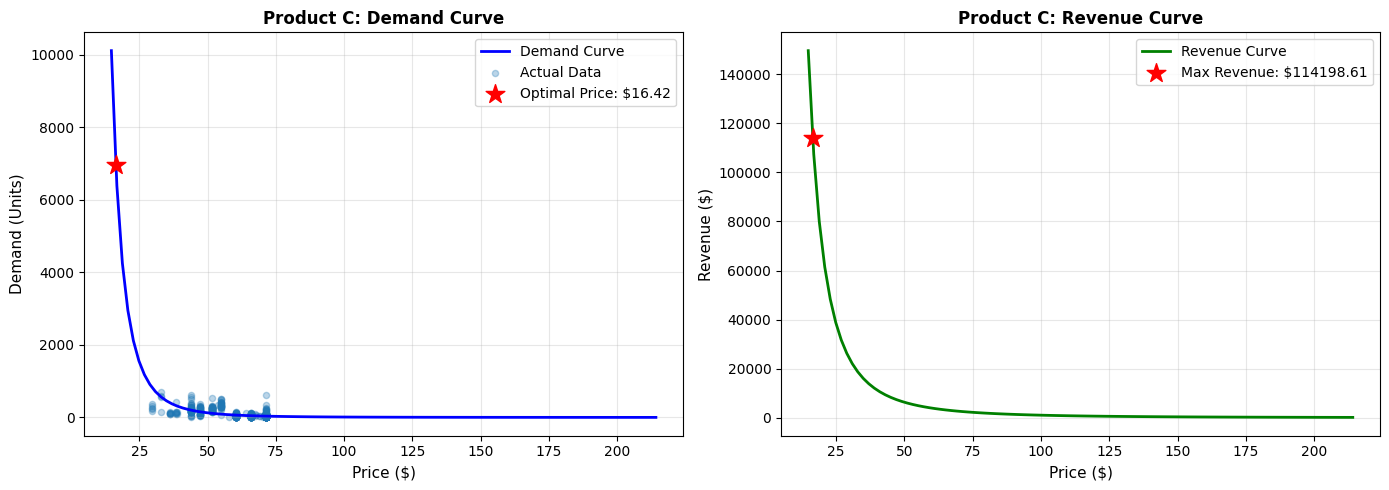


Product C:
  Optimal Price: $16.42
  Max Revenue: $114198.61
  Demand at Optimal Price: 6956.52 units


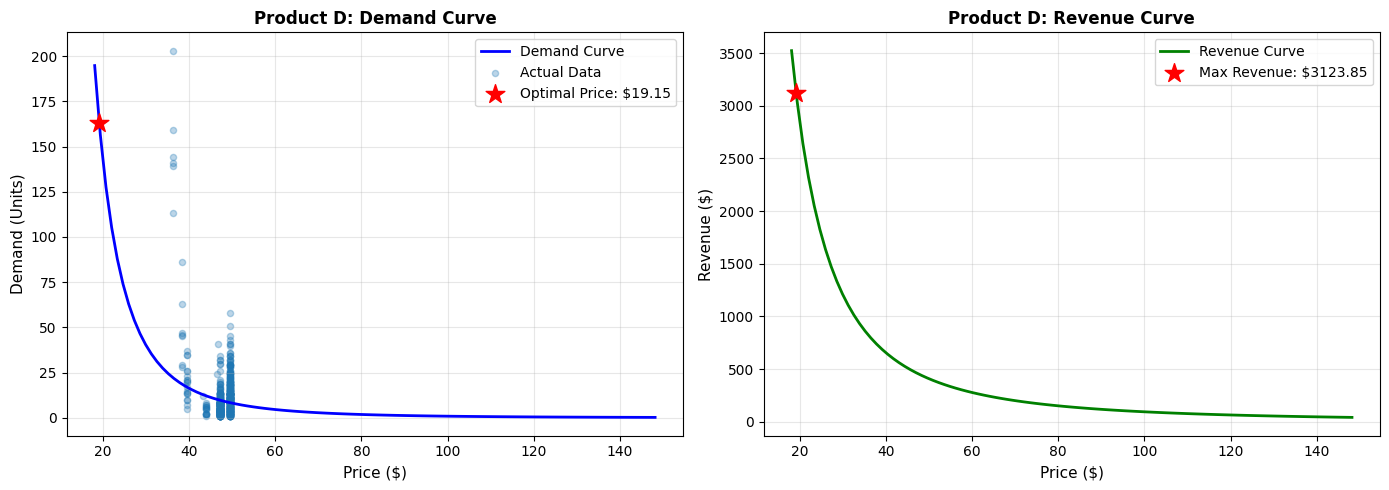


Product D:
  Optimal Price: $19.15
  Max Revenue: $3123.85
  Demand at Optimal Price: 163.10 units


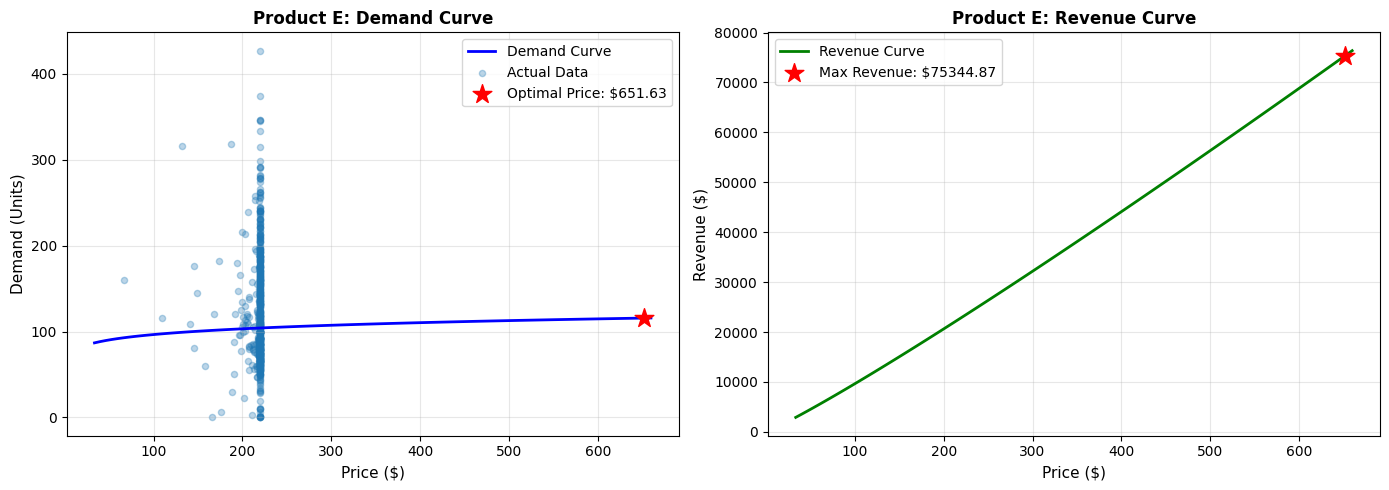


Product E:
  Optimal Price: $651.63
  Max Revenue: $75344.87
  Demand at Optimal Price: 115.63 units


In [26]:
import matplotlib.pyplot as plt

# Create a function to plot demand and revenue for a product
def plot_product_analysis(product, df, min_price_factor=0.5, max_price_factor=3):
    """
    Plot demand and revenue curves for a product with optimal price marked
    """
    # Get the relevant columns
    price_col = f'sell_price_{product}'
    sales_col = f'sales_{product}'
    
    # Prepare data
    plot_data = df[[price_col, sales_col]].copy()
    plot_data = plot_data.dropna()
    
    # Get price range
    min_price = plot_data[price_col].min() * min_price_factor
    max_price = plot_data[price_col].max() * max_price_factor
    
    # Create price array for plotting
    price_range = np.linspace(min_price, max_price, 100)
    
    # Fit regression on log scale
    log_data = df[[f'log_sell_price_{product}', f'log_sales_{product}']].copy()
    log_data = log_data.dropna()
    X_fit = sm.add_constant(log_data[f'log_sell_price_{product}'])
    y_fit = log_data[f'log_sales_{product}']
    model_fit = sm.OLS(y_fit, X_fit).fit()
    beta0_fit, beta1_fit = model_fit.params
    
    # Calculate demand and revenue for price range
    demand_range = np.exp(beta0_fit) * price_range**beta1_fit
    revenue_range = price_range * demand_range
    
    # Find optimal price
    res = minimize_scalar(lambda p: -revenue_range[np.argmin(np.abs(price_range - p))],
                          bounds=(min_price, max_price),
                          method='bounded')
    optimal_price = res.x
    optimal_demand = np.exp(beta0_fit) * optimal_price**beta1_fit
    optimal_revenue = optimal_price * optimal_demand
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: Demand curve
    ax1.plot(price_range, demand_range, 'b-', linewidth=2, label='Demand Curve')
    ax1.scatter(plot_data[price_col], plot_data[sales_col], alpha=0.3, s=20, label='Actual Data')
    ax1.scatter(optimal_price, optimal_demand, color='red', s=200, marker='*', 
                label=f'Optimal Price: ${optimal_price:.2f}', zorder=5)
    ax1.set_xlabel('Price ($)', fontsize=11)
    ax1.set_ylabel('Demand (Units)', fontsize=11)
    ax1.set_title(f'Product {product}: Demand Curve', fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot 2: Revenue curve
    ax2.plot(price_range, revenue_range, 'g-', linewidth=2, label='Revenue Curve')
    ax2.scatter(optimal_price, optimal_revenue, color='red', s=200, marker='*',
                label=f'Max Revenue: ${optimal_revenue:.2f}', zorder=5)
    ax2.set_xlabel('Price ($)', fontsize=11)
    ax2.set_ylabel('Revenue ($)', fontsize=11)
    ax2.set_title(f'Product {product}: Revenue Curve', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return optimal_price, optimal_revenue, optimal_demand

# Plot analysis for each product
products = ['A', 'B', 'C', 'D', 'E']
for product in products:
    try:
        opt_price, opt_revenue, opt_demand = plot_product_analysis(product, df_merge_daily)
        print(f"\nProduct {product}:")
        print(f"  Optimal Price: ${opt_price:.2f}")
        print(f"  Max Revenue: ${opt_revenue:.2f}")
        print(f"  Demand at Optimal Price: {opt_demand:.2f} units")
    except Exception as e:
        print(f"Could not plot Product {product}: {str(e)}")